In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_scws(rid):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    return df1, df2

In [3]:
melb_scw, melb_null = load_scws("2")
bris_scw, bris_null = load_scws("66")
namoi_scw, namoi_null = load_scws("69")
perth_scw, perth_null = load_scws("70")
syd_scw, syd_null = load_scws("71")

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


In [4]:
df_scw = pd.concat([melb_scw, bris_scw, namoi_scw, perth_scw, syd_scw], axis=0)
df_null = pd.concat([melb_null, bris_null, namoi_null, perth_null, syd_null], axis=0)

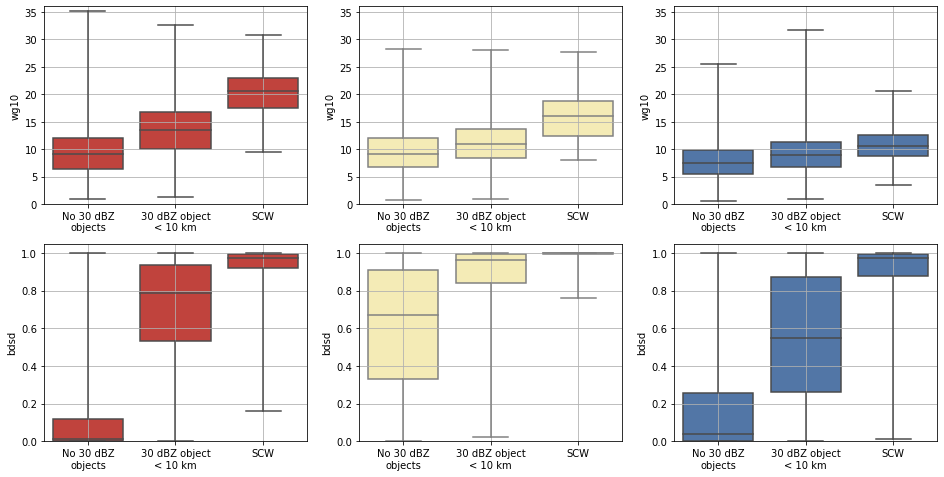

In [24]:
def plot_box_clusters(event,null,v,ax1,ax2,ax3,y0=None,y1=None,yscale="linear"):

    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    data1=null.query("cluster==0")
    data2=event.query("cluster==0")
    sns.boxplot(data=[data1.query("(in10km==0)")[v],
                     data1.query("(in10km==1)")[v],
                     data2[v]],whis=10000,color=p[0],ax=ax1)
    ax1.set_yscale(yscale); ax1.set_ylim([y0,y1])
    ax1.set_ylabel(v)
    ax1.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
    ax1.grid()

    data1=null.query("cluster==2")
    data2=event.query("cluster==2")
    sns.boxplot(data=[data1.query("(in10km==0)")[v],
                     data1.query("(in10km==1)")[v],
                     data2[v]],whis=10000,color=p[1],ax=ax2)
    ax2.set_yscale(yscale); ax2.set_ylim([y0,y1])
    ax2.set_ylabel(v)
    ax2.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
    ax2.grid()

    data1=null.query("cluster==1")
    data2=event.query("cluster==1")
    sns.boxplot(data=[data1.query("(in10km==0)")[v],
                     data1.query("(in10km==1)")[v],
                     data2[v]],whis=10000,color=p[2],ax=ax3)
    ax3.set_yscale(yscale); ax3.set_ylim([y0,y1])
    ax3.set_ylabel(v)
    ax3.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
    ax3.grid()
    
plt.figure(figsize=[16,8])

plot_box_clusters(df_scw,df_null,"wg10",plt.subplot(2,3,1),plt.subplot(2,3,2),plt.subplot(2,3,3),y0=0,y1=36)
plot_box_clusters(df_scw,df_null,"bdsd",plt.subplot(2,3,4),plt.subplot(2,3,5),plt.subplot(2,3,6),y0=0,y1=1.05)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_boxplot.jpeg",dpi=1000,bbox_inches="tight")

In [6]:
def skill(events, nulls, t, v):
    
    hits = (events[v]>=t).sum()
    misses = (events[v]<t).sum()    
    fa = (nulls[v]>=t).sum()
    cn = (nulls[v]<t).sum()
    
    #TSS
    return (( (hits) / (hits+misses) )  - ( (fa) / (fa+cn) ))

def plot_skill(events, nulls, v, ax, color):
    x=np.linspace(0,nulls[v].quantile(.975),50)
    ax.plot(x,[skill(events,nulls,i,v) for i in x],color=color,marker="x")
    ax.set_facecolor("lightgray"); ax.set_ylim([0,1]); ax.set_xlabel(v+" threshold"); ax.set_ylabel("TSS"); ax.grid()

p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    

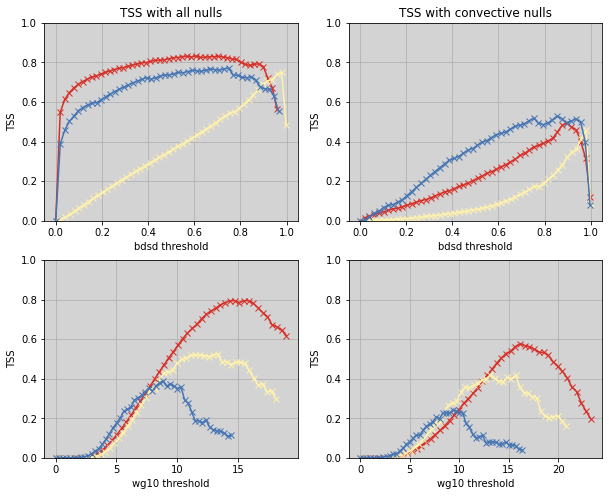

In [12]:
#For all locations combined...

plt.figure(figsize=[10,8]); 

rows=2; cols=2

ax=plt.subplot(rows,cols,1); ax2=plt.subplot(rows,cols,2)
v="bdsd"
plot_skill(df_scw.query("cluster==0"),df_null.query("cluster==0"),v,ax,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("cluster==2"),v,ax,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("cluster==1"),v,ax,p[2])
plot_skill(df_scw.query("cluster==0"),df_null.query("(cluster==0) & (in10km==1)"),v,ax2,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("(cluster==2) & (in10km==1)"),v,ax2,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("(cluster==1) & (in10km==1)"),v,ax2,p[2])
ax.set_title("TSS with all nulls")
ax2.set_title("TSS with convective nulls")

ax=plt.subplot(rows,cols,3); ax2=plt.subplot(rows,cols,4)
v="wg10"
plot_skill(df_scw.query("cluster==0"),df_null.query("cluster==0"),v,ax,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("cluster==2"),v,ax,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("cluster==1"),v,ax,p[2])
plot_skill(df_scw.query("cluster==0"),df_null.query("(cluster==0) & (in10km==1)"),v,ax2,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("(cluster==2) & (in10km==1)"),v,ax2,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("(cluster==1) & (in10km==1)"),v,ax2,p[2])

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_tss.jpeg",dpi=1000,bbox_inches="tight")

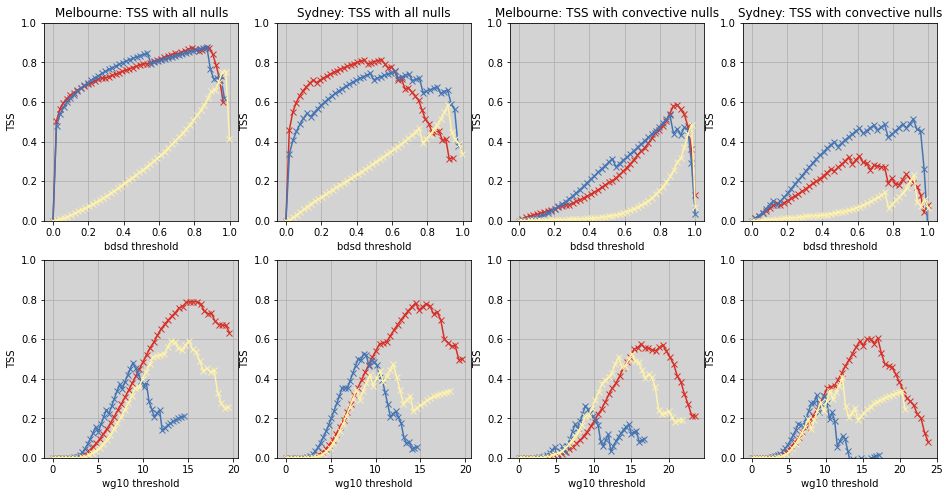

In [29]:
#SCWs versus all other events - regional variations.

plt.figure(figsize=[16,8]); 

ax=plt.subplot(2,4,1)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("cluster==0"),"bdsd",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("cluster==1"),"bdsd",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("cluster==2"),"bdsd",ax,p[1])
ax.set_title("Melbourne: TSS with all nulls")

ax=plt.subplot(2,4,5)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("cluster==0"),"wg10",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("cluster==1"),"wg10",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("cluster==2"),"wg10",ax,p[1])

ax=plt.subplot(2,4,3)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("(cluster==0) & (in10km==1)"),"bdsd",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("(cluster==1) & (in10km==1)"),"bdsd",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("(cluster==2) & (in10km==1)"),"bdsd",ax,p[1])
ax.set_title("Melbourne: TSS with convective nulls")

ax=plt.subplot(2,4,7)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("(cluster==0) & (in10km==1)"),"wg10",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("(cluster==1) & (in10km==1)"),"wg10",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("(cluster==2) & (in10km==1)"),"wg10",ax,p[1])

ax=plt.subplot(2,4,2)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("cluster==0"),"bdsd",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("cluster==1"),"bdsd",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("cluster==2"),"bdsd",ax,p[1])
ax.set_title("Sydney: TSS with all nulls")

ax=plt.subplot(2,4,6)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("cluster==0"),"wg10",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("cluster==1"),"wg10",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("cluster==2"),"wg10",ax,p[1])

ax=plt.subplot(2,4,4)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("(cluster==0) & (in10km==1)"),"bdsd",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("(cluster==1) & (in10km==1)"),"bdsd",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("(cluster==2) & (in10km==1)"),"bdsd",ax,p[1])
ax.set_title("Sydney: TSS with convective nulls")

ax=plt.subplot(2,4,8)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("(cluster==0) & (in10km==1)"),"wg10",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("(cluster==1) & (in10km==1)"),"wg10",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("(cluster==2) & (in10km==1)"),"wg10",ax,p[1])


plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_tss_regional.jpeg",dpi=1000,bbox_inches="tight")